In [1]:
import numpy as np
import data_loader

train_dir_path = './aclImdb/train/'
train_texts, train_labels, valid_texts, valid_labels = data_loader.load_train_data(train_dir_path, valid_rate=0.1)

test_dir_path = './aclImdb/test/'
test_texts, test_labels = data_loader.load_test_data(test_dir_path)

vocab_file_path = './aclImdb/imdb.vocab'
vocab_dict = data_loader.load_vocab_dict(vocab_file_path)

In [2]:
print(train_labels.shape)
print(valid_labels.shape)
print(test_labels.shape)

(22523,)
(2477,)
(25000,)


In [3]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

stop_words = set(stopwords.words("english")) 

lemmatizer = WordNetLemmatizer()

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]    
    clean = []
    for i, review in enumerate(reviews):
        clean.append(clean_text(review))
    return clean

def clean_text(text):
    # text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    # text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

train_texts_clean = preprocess_reviews(train_texts)
valid_texts_clean = preprocess_reviews(valid_texts)
test_texts_clean = preprocess_reviews(test_texts)

print(train_texts[0], '\n')
print(train_texts_clean[0], '\n')

It was originally meant to be a film that Gene Kelly would star in, but when the makers couldn't get him they got "the greatest actor in the world", and the result is pretty good. Basically Nathan Detroit (Frank Sinatra) is having trouble doing what he does best, setting up a high stakes crap dice game, because he needs $1000 to get the place. So to get the money he needs, he has a $1000 bet with old friend Sky Masterson (Marlon Brando) that he can't get Sergeant Sarah Brown (Great Expectations' Golden Globe winning, and BAFTA nominated Jean Simmons) to go with him to Havana. Meanwhile, Nathan is having trouble trying to get rid of the woman who wants him to ask her hand in marriage, Miss Adelaide (Vivian Blaine). Also starring Robert Keith as Lieutenant Brannigan, Stubby Kaye as Nicely Nicely Johnson and B.S. Pulley as Big Jule. An interesting romantic comedy musical, with Brando singing all his own songs, and Sinatra being smooth and cool. It was nominated the Oscars for Best Art Dir

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

SAMPLE = len(train_texts) #1000
N_GRAM = 2 #3
MAX_FEATURES = 6000 #12000

THRESHOLD = 100
THRESHOLD_UPPER = 13000

# use tfidf as the feature
def vectorize(train, valid, test):  
    tfidf = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1, N_GRAM))
    tfidf.fit(train[:SAMPLE])
    Xtr = tfidf.transform(train[:SAMPLE])
    Xva = tfidf.transform(valid)
    Xte = tfidf.transform(test)
    return Xtr, Xva, Xte, tfidf

def vectorize2(train, valid, test, max_f=MAX_FEATURES):  
    tfidf = TfidfVectorizer(max_features=12000, ngram_range=(1, N_GRAM))
    tfidf.fit(train[:SAMPLE])
    Xtr = tfidf.transform(train[:SAMPLE])
    Xva = tfidf.transform(valid)
    Xte = tfidf.transform(test)
    return Xtr, Xva, Xte, tfidf

# use word count as the features
def build_up_vocab(train):
    cv = CountVectorizer(binary=True, ngram_range=(1, N_GRAM))
    cv.fit(train[:SAMPLE])
    Xtr = cv.transform(train[:SAMPLE])   
    features_count = np.sum(Xtr,axis=0)
    useful_idx = []
    max_idx = sorted(range(features_count.shape[1]), key=lambda k: features_count[0, k], reverse = True)
    useful_idx = max_idx[0:6000]   # get 6000 features with max occurance
    vocabulary = []
    features = cv.get_feature_names()
    for i, idx in enumerate(useful_idx):
        vocabulary.append(features[idx])
    return vocabulary

def vectorize3(train, valid, test, vocab):
    cv = CountVectorizer(binary=False, ngram_range=(1, N_GRAM), vocabulary=vocab)
    cv.fit(train[:SAMPLE])
    Xtr = cv.transform(train[:SAMPLE])
    Xva = cv.transform(valid)
    Xte = cv.transform(test)
    return Xtr, Xva, Xte, cv

def show_crucial_words(learner, tfidf):
    feature_to_coef = {
        word: coef for word, coef in zip(
            tfidf.get_feature_names(), learner.coef_[0]
        )
    }

    best_positive = sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]
    x_value = [tup[0] for tup in best_positive ]
    y_value = [tup[1] for tup in best_positive ]
    plt.figure(figsize=(20,4))
    plt.bar(x_value, y_value, alpha = 1, color = 'b', align="center")
    plt.autoscale()
    # plt.xlabel("Singular Values")
    plt.ylabel("coef value")
    plt.title("First 10 positive words")
    plt.show()
    
    best_negative = sorted(feature_to_coef.items(), key=lambda x: x[1])[:10]
    x_value = [tup[0] for tup in best_negative ]
    y_value = [tup[1] for tup in best_negative ]
    plt.figure(figsize=(20,4))
    plt.bar(x_value, y_value, alpha = 1, color = 'r', align="center")
    plt.autoscale()
    plt.ylabel("coef value")
    plt.title("First 10 negative words")
    plt.show()

In [5]:
from sklearn.decomposition import TruncatedSVD

COMPONENTS = 6000

def PCA2():
    svd = TruncatedSVD(n_components=COMPONENTS, n_iter=7, random_state=42)
    svd.fit(Xtr_all)
    Xtr2 = svd.transform(Xtr_all)
    Xva2 = svd.transform(Xva_all)
    Xte2 = svd.transform(Xte_all)
    return Xtr2, Xva2, Xte2, svd

In [6]:
def PC_info(pc, tfidf):
    feature_to_coef = {
        word: coef for word, coef in zip(
            tfidf.get_feature_names(), pc
        )
    }    
    best_ten = sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]
    words = ""
    for i, tup in enumerate(best_ten):
        words += tup[0] + ', '
    return words

def show_crucial_PC(learner, components, tfidf):
    idx_to_coef = {
        idx: coef for idx, coef in zip(
            list(range(0, COMPONENTS, 1)), learner.coef_[0]
        )
    } 
    best_pos = sorted(idx_to_coef.items(), key=lambda x: x[1], reverse=True)[:5]
    best_neg = sorted(idx_to_coef.items(), key=lambda x: x[1])[:5]
    
    x_value = [str(tup[0]) for tup in best_pos ]
    y_value = [tup[1] for tup in best_pos ]
    plt.figure(figsize=(6,4))
    plt.bar(x_value, y_value, alpha = 1, color = 'b', align="center")
    plt.autoscale()
    plt.xlabel("Principle Component")
    plt.ylabel("coef value")
    plt.title("Top 5 positive PC")
    plt.show()
    for i, tup in enumerate(best_pos):
        print('pc#'+str(tup[0])+':', PC_info(components[tup[0]], tfidf), '\n')
    
    x_value = [str(tup[0]) for tup in best_neg ]
    y_value = [tup[1] for tup in best_neg ]
    plt.figure(figsize=(6,4))
    plt.bar(x_value, y_value, alpha = 1, color = 'r', align="center")
    plt.autoscale()
    plt.xlabel("Principle Component")
    plt.ylabel("coef value")
    plt.title("Top 5 negative PC")
    plt.show()
    for i, tup in enumerate(best_neg):
        print('pc#'+str(tup[0])+':', PC_info(components[tup[0]], tfidf), '\n')


In [7]:
# use word count as the features
# vocab = build_up_vocab(train_texts_clean)
# Xtr, Xva, Xte, cv = vectorize(train_texts_clean, valid_texts_clean, test_texts_clean, vocab)

# use tfidf as the features
Xtr, Xva, Xte, tfidf = vectorize(train_texts_clean, valid_texts_clean, test_texts_clean)
Ytr, Yva, Yte = train_labels[:SAMPLE], valid_labels, test_labels

In [8]:
Xtr_all, Xva_all, Xte_all, tfidf2 = vectorize2(train_texts_clean, valid_texts_clean, test_texts_clean)
print(Xtr.shape)
print(Xtr_all.shape)

(22523, 6000)
(22523, 12000)


In [9]:
Xtr2, Xva2, Xte2, svd = PCA2()
print('PCA Done')
print(svd.components_.shape)

PCA Done
(6000, 12000)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.8280177634234962, 0.8359010788971274
Accuracy for C=0.05: 0.8582963262010497, 0.8637836877858189
Accuracy for C=0.25: 0.8853451756156641, 0.8954846157261466
Accuracy for C=0.5: 0.8889786031489705, 0.9074279625271944
Accuracy for C=1: 0.8938231731933791, 0.9181281356835235
Accuracy for C=2: 0.8938231731933791, 0.9307818674244106
Accuracy for C=5: 0.8962454582155833, 0.9443679793988368
Accuracy for C=10: 0.8922083165119096, 0.953869377969187
Best learner on test data: 0.878


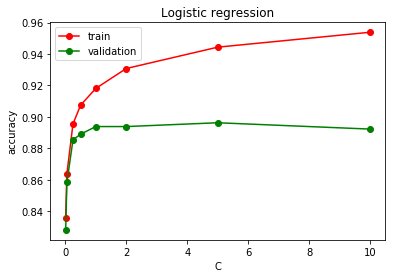

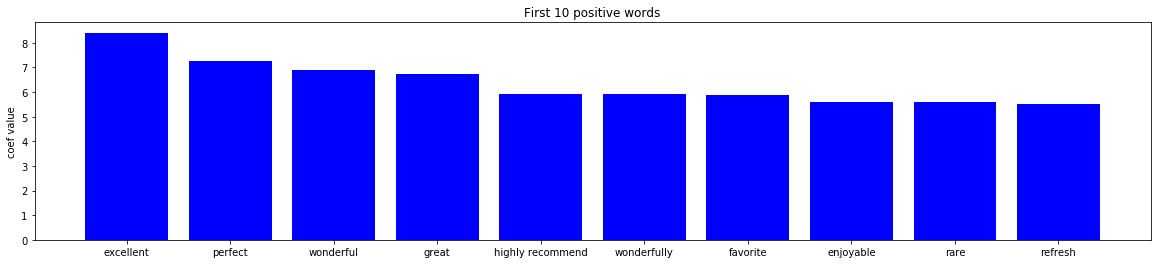

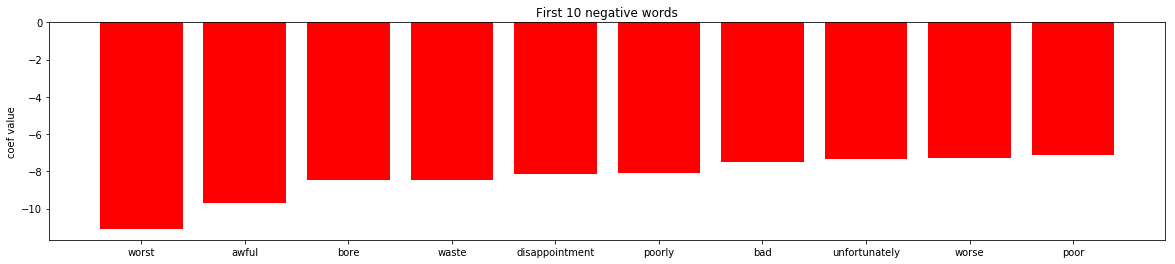

In [10]:
def LogisticRegression_routine(Xtr, Ytr, Xva, Yva, Xte, Yte):
    best_score = 0
    best_learner = LogisticRegression(solver='warn', penalty='l2')
    accuracy_tr = []
    accuracy_va = []
    C = [0.01, 0.05, 0.25, 0.5, 1, 2, 5, 10];
    for i, c in enumerate(C):
        learner = LogisticRegression(C=c, solver='warn')
        learner.fit(Xtr, Ytr)
        score = accuracy_score(Yva, learner.predict(Xva))
        score2 = accuracy_score(Ytr, learner.predict(Xtr))
        accuracy_tr.append(score2)
        accuracy_va.append(score)
        print ("Accuracy for C=%s: %s, %s" %(c, score, score2))
        if (score > best_score):
            best_learner = learner
            best_score = score
    print ("Best learner on test data:", accuracy_score(Yte, best_learner.predict(Xte)) )
    plt.figure()
    plt.title('Logistic regression')
    plt.xlabel("C")
    plt.ylabel("accuracy")
    plt.plot(C, accuracy_tr, '-ro', label='train')
    plt.plot(C, accuracy_va, '-go', label='validation')
    plt.legend()
    return best_learner

best_logistic_learner = LogisticRegression_routine(Xtr, Ytr, Xva, Yva, Xte, Yte)
show_crucial_words(best_logistic_learner, tfidf)

Accuracy for C=0.01: 0.8259991925716592, 0.8367002619544466


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.05: 0.8562777553492128, 0.8639612840207788


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.25: 0.884134033104562, 0.8965057940771656


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.5: 0.8909971740008075, 0.9093815211117524


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=1: 0.8962454582155833, 0.9226568396749989


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=2: 0.9027048849414614, 0.9364205478843849


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=5: 0.9014937424303593, 0.9498290636238512


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=10: 0.8982640290674203, 0.9613284198374994
Best learner on test data: 0.88724


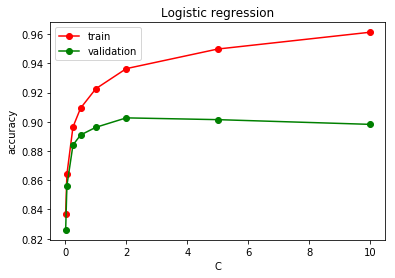

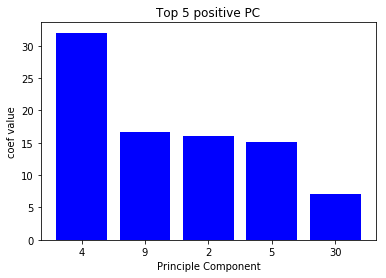

pc#4: movie, wa, love, great, story, performance, book, life, film, movie wa,  

pc#9: horror, series, zombie, episode, horror movie, horror film, film, gore, fan, movie,  

pc#2: show, episode, series, season, love, life, family, tv, character, play,  

pc#5: show, film, watch, see, ever, episode, great, funny, love, ive,  

pc#30: game, good, ha, life, scene, first, love, people, time, think,  



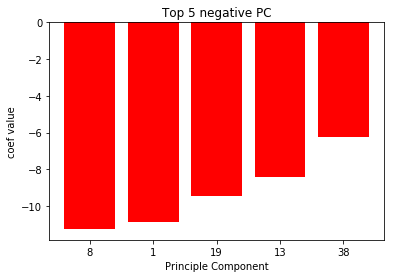

pc#8: book, series, episode, story, war, character, read, movie, make, would,  

pc#1: movie, wa, movie wa, bad, watch, watch movie, see movie, think, dont, worst,  

pc#19: make, kid, like, series, film, episode, would, family, movie, worst,  

pc#13: watch, time, character, horror, waste, comedy, plot, waste time, story, funny,  

pc#38: great, ha, would, woman, really, man, series, look, original, find,  



In [11]:
# Learn by PCA
best_logistic_learner = LogisticRegression_routine(Xtr2, Ytr, Xva2, Yva, Xte2, Yte)
show_crucial_PC(best_logistic_learner, svd.components_, tfidf2)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


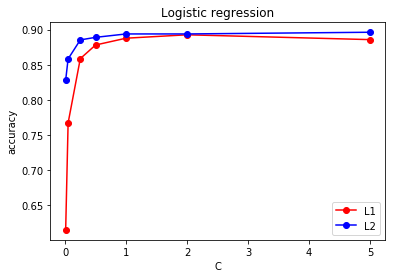

In [12]:
# Compare L1 and L2 regulation
def LogisticRegression_routine2(Xtr, Ytr, Xva, Yva, Xte, Yte):
    accuracy_va1 = []
    accuracy_va2 = []
    C = [0.01, 0.05, 0.25, 0.5, 1, 2, 5];
    for i, c in enumerate(C):
        learner1 = LogisticRegression(penalty='l1', solver='warn', C=c)
        learner2 = LogisticRegression(penalty='l2', solver='warn', C=c)
        learner1.fit(Xtr, Ytr)
        learner2.fit(Xtr, Ytr)
        accuracy_va1.append(accuracy_score(Yva, learner1.predict(Xva)))
        accuracy_va2.append(accuracy_score(Yva, learner2.predict(Xva)))
    plt.figure()
    plt.title('Logistic regression')
    plt.xlabel("C")
    plt.ylabel("accuracy")
    plt.plot(C, accuracy_va1, '-ro', label='L1')
    plt.plot(C, accuracy_va2, '-bo', label='L2')
    plt.legend()

LogisticRegression_routine2(Xtr, Ytr, Xva, Yva, Xte, Yte)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

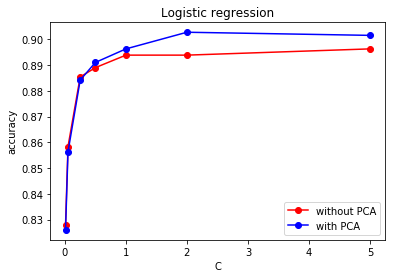

In [13]:
# Compare PCA or not
def LogisticRegression_routine3(Xtr, Ytr, Xva, Yva, Xte, Yte, Xtr2, Xva2, Xte2):
    accuracy_va1 = []
    accuracy_va2 = []
    C = [0.01, 0.05, 0.25, 0.5, 1, 2, 5];
    for i, c in enumerate(C):
        learner1 = LogisticRegression(penalty='l2', solver='warn', C=c)
        learner2 = LogisticRegression(penalty='l2', solver='warn', C=c)
        learner1.fit(Xtr, Ytr)
        learner2.fit(Xtr2, Ytr)
        accuracy_va1.append(accuracy_score(Yva, learner1.predict(Xva)))
        accuracy_va2.append(accuracy_score(Yva, learner2.predict(Xva2)))
    plt.figure()
    plt.title('Logistic regression')
    plt.xlabel("C")
    plt.ylabel("accuracy")
    plt.plot(C, accuracy_va1, '-ro', label='without PCA')
    plt.plot(C, accuracy_va2, '-bo', label='with PCA')
    plt.legend()

LogisticRegression_routine3(Xtr, Ytr, Xva, Yva, Xte, Yte, Xtr2, Xva2, Xte2)

Accuracy for C=0.01: 0.8675817521194994, 0.8768370110553656
Accuracy for C=0.05: 0.8918046023415422, 0.9075167606446743
Accuracy for C=0.25: 0.8970528865563181, 0.935310571415886
Accuracy for C=0.5: 0.8954380298748487, 0.9449451671624561
Accuracy for C=1: 0.89059345983044, 0.953913777027927
Accuracy for C=2: 0.8825191764230924, 0.9636371708919771
Accuracy for C=5: 0.863948324586193, 0.9751809261643654
Best learner on test data: 0.88284


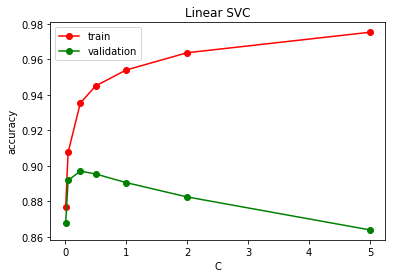

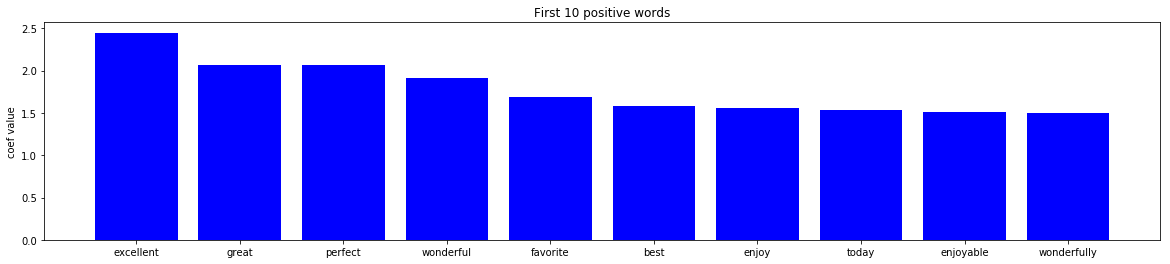

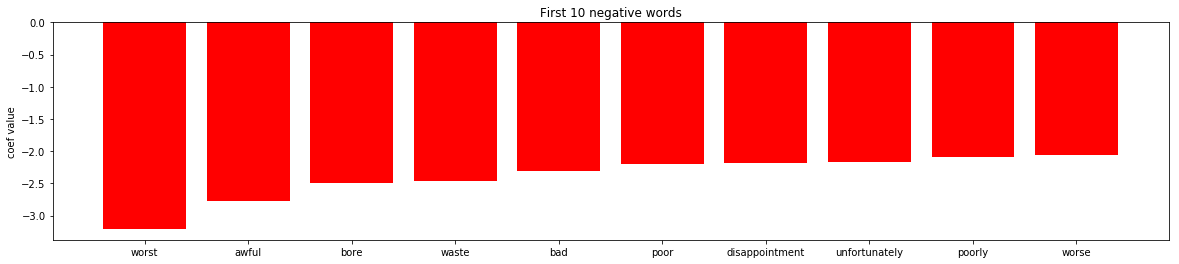

In [14]:
def LinearSVC_routine(Xtr, Ytr, Xva, Yva, Xte, Yte):
    best_score = 0
    best_learner = LinearSVC()
    accuracy_tr = []
    accuracy_va = []
    C = [0.01, 0.05, 0.25, 0.5, 1, 2, 5];
    for i, c in enumerate(C):
        learner = LinearSVC(C=c)
        learner.fit(Xtr, Ytr)
        score = accuracy_score(Yva, learner.predict(Xva))
        score2 = accuracy_score(Ytr, learner.predict(Xtr))
        accuracy_tr.append(score2)
        accuracy_va.append(score)
        print ("Accuracy for C=%s: %s, %s" %(c, score, score2))
        if (score > best_score):
            best_learner = learner
            best_score = score
    print ("Best learner on test data:", accuracy_score(Yte, best_learner.predict(Xte)) )
    plt.figure()
    plt.title('Linear SVC')
    plt.xlabel("C")
    plt.ylabel("accuracy")
    plt.plot(C, accuracy_tr, '-ro', label='train')
    plt.plot(C, accuracy_va, '-go', label='validation')
    plt.legend()
    return best_learner

best_linearSVC_learner = LinearSVC_routine(Xtr, Ytr, Xva, Yva, Xte, Yte)
show_crucial_words(best_linearSVC_learner, tfidf)

Accuracy for C=0.01: 0.870407751312071, 0.8764818185854459
Accuracy for C=0.05: 0.8930157448526443, 0.9104026994627714
Accuracy for C=0.25: 0.9035123132821962, 0.9405940594059405
Accuracy for C=0.5: 0.901090028259992, 0.9512054344447898
Accuracy for C=1: 0.8950343157044812, 0.9618612085423789
Accuracy for C=2: 0.89059345983044, 0.9698530391155707
Accuracy for C=5: 0.8821154622527251, 0.9821515783865382
Best learner on test data: 0.88688


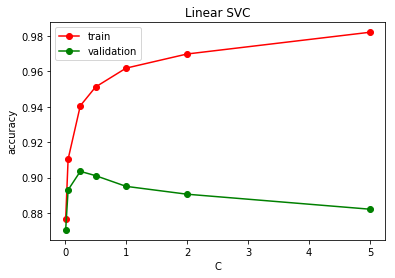

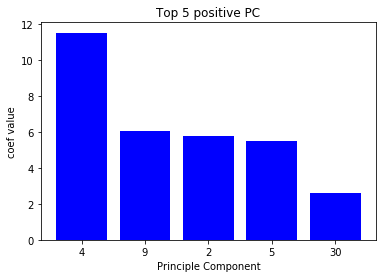

pc#4: movie, wa, love, great, story, performance, book, life, film, movie wa,  

pc#9: horror, series, zombie, episode, horror movie, horror film, film, gore, fan, movie,  

pc#2: show, episode, series, season, love, life, family, tv, character, play,  

pc#5: show, film, watch, see, ever, episode, great, funny, love, ive,  

pc#30: game, good, ha, life, scene, first, love, people, time, think,  



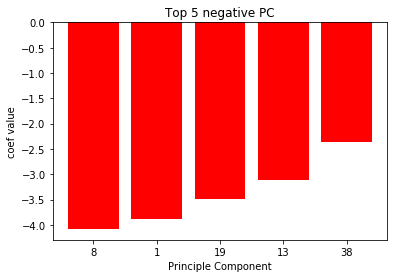

pc#8: book, series, episode, story, war, character, read, movie, make, would,  

pc#1: movie, wa, movie wa, bad, watch, watch movie, see movie, think, dont, worst,  

pc#19: make, kid, like, series, film, episode, would, family, movie, worst,  

pc#13: watch, time, character, horror, waste, comedy, plot, waste time, story, funny,  

pc#38: great, ha, would, woman, really, man, series, look, original, find,  



In [15]:
best_linearSVC_learner = LinearSVC_routine(Xtr2, Ytr, Xva2, Yva, Xte2, Yte)
show_crucial_PC(best_linearSVC_learner, svd.components_, tfidf2)

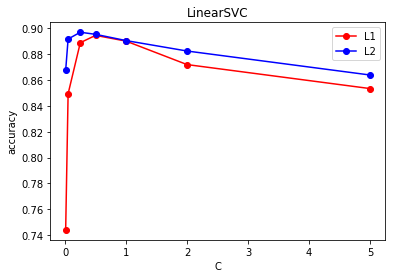

In [16]:
# Compare L1 and L2 regulation
def LinearSVC_routine2(Xtr, Ytr, Xva, Yva, Xte, Yte):
    accuracy_va1 = []
    accuracy_va2 = []
    C = [0.01, 0.05, 0.25, 0.5, 1, 2, 5];
    for i, c in enumerate(C):
        learner1 = LinearSVC(penalty='l1', C=c, dual=False)
        learner2 = LinearSVC(penalty='l2', C=c)
        learner1.fit(Xtr, Ytr)
        learner2.fit(Xtr, Ytr)
        accuracy_va1.append(accuracy_score(Yva, learner1.predict(Xva)))
        accuracy_va2.append(accuracy_score(Yva, learner2.predict(Xva)))
    plt.figure()
    plt.title('LinearSVC')
    plt.xlabel("C")
    plt.ylabel("accuracy")
    plt.plot(C, accuracy_va1, '-ro', label='L1')
    plt.plot(C, accuracy_va2, '-bo', label='L2')
    plt.legend()

LinearSVC_routine2(Xtr, Ytr, Xva, Yva, Xte, Yte)

In [17]:
knn_test_set = [1,5,10,20,50,100,200,500,800,1000]
#knn_test_set = range(100,200,10)
knn_tra_acc = [0]*len(knn_test_set)
knn_va_acc = [0]*len(knn_test_set)
def KNN_routine(Xtr, Ytr, Xva, Yva, Xte, Yte):
    best_score = 0
    best_learner = KNeighborsClassifier()
    for i,k in enumerate(knn_test_set):
        learner = KNeighborsClassifier(n_neighbors=k)
        learner.fit(Xtr, Ytr)
        knn_tra_acc[i] = accuracy_score(Ytr, learner.predict(Xtr))
        knn_va_acc[i] = accuracy_score(Yva, learner.predict(Xva))
        print ("Accuracy for K=%s: tra = %s, va = %s" %(k, knn_tra_acc[i], knn_va_acc[i]))
        #score = accuracy_score(Yva, learner.predict(Xva))
        #print ("Accuracy for K=%s: %s" %(k, score))
        
        #if (score > best_score):
        if (knn_va_acc[i] > best_score):
            best_learner = learner
            #best_score = score
            best_score = knn_va_acc[i]
    print ("Best learner on test data:", accuracy_score(Yte, best_learner.predict(Xte)) )
    return best_learner

best_KNN_learner = KNN_routine(Xtr, Ytr, Xva, Yva, Xte, Yte)
# show_crucial_words(best_KNN_learner, cv)

Accuracy for K=1: tra = 1.0, va = 0.7178037949132015
Accuracy for K=5: tra = 0.8435821160591396, va = 0.7678643520387566
Accuracy for K=10: tra = 0.8275540558540159, va = 0.7884537747274929
Accuracy for K=20: tra = 0.8193402299871243, va = 0.8013726281792491
Accuracy for K=50: tra = 0.819562225280824, va = 0.8146951958013726
Accuracy for K=100: tra = 0.8201394130444435, va = 0.8171174808235769
Accuracy for K=200: tra = 0.8221817697464814, va = 0.8243843358901898
Accuracy for K=500: tra = 0.8172978732850864, va = 0.8231731933790876
Accuracy for K=800: tra = 0.8109044088265329, va = 0.8211546225272507
Accuracy for K=1000: tra = 0.8076188784797762, va = 0.8211546225272507
Best learner on test data: 0.80292


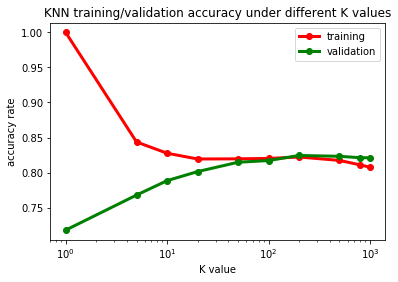

In [18]:
# KNN plot
import matplotlib.pyplot as plt
plt.figure()
plt.semilogx(knn_test_set, knn_tra_acc, '-ro', knn_test_set, knn_va_acc, '-go', linewidth = 3)
plt.xlabel("K value")
plt.ylabel("accuracy rate");
plt.title('KNN training/validation accuracy under different K values')
plt.legend(labels = ["training", "validation"]);

In [19]:
mlp_test_d = range(1,14,2)
mlp_test_w = range(1,20,3)
#mlp_test_d = range(10,26,5)
#mlp_test_w = range(10,100,5)
mlp_tra_acc = [[0]*len(mlp_test_w) for i in range(len(mlp_test_d))]
mlp_va_acc = [[0]*len(mlp_test_w) for i in range(len(mlp_test_d))]
def MLPClassifier_routine(Xtr, Ytr, Xva, Yva, Xte, Yte):
    best_score = 0
    best_w = 0
    best_d = 0
    best_learner = MLPClassifier()
    for i,d in enumerate(mlp_test_d):
        for j,w in enumerate(mlp_test_w):
            size = [w]*d
            #learner = MLPClassifier(hidden_layer_sizes=size, activation='logistic')
            learner = MLPClassifier(hidden_layer_sizes=size, activation='tanh')
            learner.fit(Xtr, Ytr)
            mlp_tra_acc[i][j] = accuracy_score(Ytr, learner.predict(Xtr))
            mlp_va_acc[i][j] = accuracy_score(Yva, learner.predict(Xva))
            #score = accuracy_score(Yva, learner.predict(Xva))
            print ("Accuracy for (%s, %s): %s" %(d, w, mlp_va_acc[i][j]))
            #prcuracy for (%s, %s): %s" %(d, w, score))
            #if (score > best_score):
            if (mlp_va_acc[i][j] > best_score):
                best_learner = learner
                best_score = mlp_va_acc[i][j]
                best_d = d
                best_w = w
            #    best_score = score
    print ("Best learner on test data:", accuracy_score(Yte, best_learner.predict(Xte)) )
    return best_learner

best_MLP_learner = MLPClassifier_routine(Xtr, Ytr, Xva, Yva, Xte, Yte)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy for (1, 1): 0.8510294711344368
Accuracy for (1, 4): 0.8425514735567219
Accuracy for (1, 7): 0.8441663302381913
Accuracy for (1, 10): 0.8421477593863544
Accuracy for (1, 13): 0.8409366168752523
Accuracy for (1, 16): 0.8413403310456197
Accuracy for (1, 19): 0.8389180460234155
Accuracy for (3, 1): 0.8748486071861122
Accuracy for (3, 4): 0.8643520387565603
Accuracy for (3, 7): 0.8679854662898667
Accuracy for (3, 10): 0.8615260395639887
Accuracy for (3, 13): 0.8570851836899476
Accuracy for (3, 16): 0.8550666128381106
Accuracy for (3, 19): 0.8574888978603149
Accuracy for (5, 1): 0.8845377472749294
Accuracy for (5, 4): 0.8821154622527251
Accuracy for (5, 7): 0.8663706096083973
Accuracy for (5, 10): 0.8655631812676625
Accuracy for (5, 13): 0.858700040371417
Accuracy for (5, 16): 0.8619297537343561
Accuracy for (5, 19): 0.8603148970528866


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy for (7, 1): 0.8829228905934599
Accuracy for (7, 4): 0.8425514735567219
Accuracy for (7, 7): 0.8772708922083166
Accuracy for (7, 10): 0.8687928946306015
Accuracy for (7, 13): 0.8627371820750909
Accuracy for (7, 16): 0.8631408962454582
Accuracy for (7, 19): 0.8611223253936213
Accuracy for (9, 1): 0.497375857892612
Accuracy for (9, 4): 0.8813080339119903
Accuracy for (9, 7): 0.8687928946306015
Accuracy for (9, 10): 0.8599111828825192
Accuracy for (9, 13): 0.8643520387565603
Accuracy for (9, 16): 0.8603148970528866
Accuracy for (9, 19): 0.8631408962454582
Accuracy for (11, 1): 0.5026241421073879
Accuracy for (11, 4): 0.8837303189341946
Accuracy for (11, 7): 0.8881711748082358
Accuracy for (11, 10): 0.875656035526847
Accuracy for (11, 13): 0.8655631812676625
Accuracy for (11, 16): 0.8667743237787646
Accuracy for (11, 19): 0.8663706096083973
Accuracy for (13, 1): 0.497375857892612
Accuracy for (13, 4): 0.8776746063786839
Accuracy for (13, 7): 0.8800968914008882
Accuracy for (13, 10)

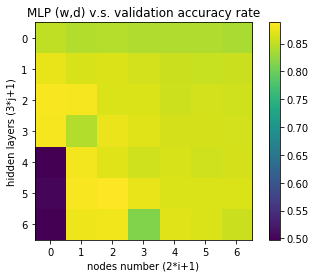

In [20]:
# MLP plot
import matplotlib.pyplot as plt
f = np.array(mlp_va_acc)
#plt.imshow(f, extent=(np.amin(mlp_test_w), np.amax(mlp_test_w), np.amin(mlp_test_d), np.amax(mlp_test_d)), aspect = 'auto')
plt.xlabel("nodes number (2*i+1)")
plt.ylabel("hidden layers (3*j+1)")
plt.title('MLP (w,d) v.s. validation accuracy rate')
plt.imshow(f)
plt.colorbar()
plt.show()